<a href="https://colab.research.google.com/github/Nakiyah24/ExplainableAI_Assignments/blob/main/Assignment5/Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Assignment 5
## Nakiyah Dhariwala

In [2]:
!pip install grad-cam

  Using cached grad-cam-1.5.5.tar.gz (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=6d218b422bf1fa5fc52f67f522d0201844a7eb54663d4de6528145b5d8272b0b
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import requests
import urllib

from io import BytesIO
from PIL import Image
from torchvision import transforms
from torchvision import models
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

### Assignment overview

The Himalayas are recognized as one of the world’s great biodiversity hotspots, home to over a thousand bird species, many of which are found nowhere else. At the same time, it is one of the most fragile ecosystems—small shifts in temperature, land use, or forest cover can dramatically affect where and how species survive. While not all Himalayan birds are endangered, many face increasing pressure from habitat loss, deforestation, and climate change. Because of this, monitoring bird populations in the region is a growing priority for conservation research.

However, most bird identification still relies on manual field observation, which is time-consuming, resource-intensive, and difficult to scale across large or remote mountain ranges. Which is why I believe deep learning would offer a way to automate part of this process by recognizing bird species directly from photographs or camera-trap images. However, just using a deep learning model to classify birds isn’t enough. To be truly useful for conservation, we also need to understand *how* the model is making its decisions—what visual features it focuses on, whether it can generalize across different environments, and if it can distinguish between similar-looking species. This interpretability is quite important for building trust in the model’s predictions, or atleast understanding why the model predicted what it did to ensure it can be effectively applied in real-world monitoring efforts.

In this project, I explore how a pretrained computer vision model can contribute to that goal by classifying three Himalayan bird species—Bonelli’s Eagle, Chestnut-bellied Rock Thrush, and Himalayan Bulbul. My focus is on two main objectives: first, to see how well a general image classification model like ResNet-50 can recognize each species, and second, to understand what visual cues it relies on when making those predictions.

To do this, I will first use ResNet-50 to generate predictions for each image and evaluate how confidently it identifies the birds (if it even identifies the birds). I shall then apply Grad-CAM, Grad-CAM++, and Score-CAM to visualize which regions of the image most strongly influence the model’s decisions. Applying these methods and looking at the visualizations should help reveal whether the model is truly attending to the bird itself—or being distracted by surrounding textures like rocks, foliage, or background patterns.

**Note:** The three birds I picked aren’t endangered, but they represent different types of species found across the Himalayas. The Himalayan Bulbul is pretty common and can even coexists well with people, while the Bonelli’s Eagle and Chestnut-bellied Rock Thrush are a bit more sensitive to changes in forest cover and altitude. I chose these three because they give a nice mix — they were easier to find images of, but still different enough to test whether the model can tell them apart. Using ResNet-50 here isn’t just about getting the labels right; it’s also about seeing how the model “looks” at each bird and what parts of the image it pays attention to, which could eventually help make bird monitoring more scalable and explainable.


Reference:
- https://science.thewire.in/environment/scientists-record-drastic-loss-of-forest-birds-in-western-himalaya/?utm_source=chatgpt.com
- https://bdj.pensoft.net/article/31588/element/2/4788541/?utm_source=chatgpt.com


Data taken from:
- https://www.kaggle.com/datasets/akash2907/bird-species-classification/data

### Tep 1: Getting the images

In [4]:
def get_img(url):
    """Fetch image from a raw GitHub URL and return as RGB PIL.Image."""
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")

In [5]:
# Bonelli’s Eagle
bonegl_1 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/bonegl/bonegl_1.jpg"
)
bonegl_2 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/bonegl/bonegl_2.jpg"
)

# Chestnut-bellied Rock Thrush
cbrtsh_1 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/cbrtsh/cbrtsh_1.jpg"
)
cbrtsh_2 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/cbrtsh/cbrtsh_2.jpg"
)

# Himalayan Bulbul
himbul_1 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/himbul/himbul_1.JPG"
)
himbul_2 = get_img(
    "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/himalayan_bird_sample/himbul/himbul_2.jpg"
)

### Step 2: Preprocess the images

In [6]:
# COnverting image to 224x244 to fit ResNet-50 specifications
img_size = 224

# torchvision pipeline:
# resizing; converting to tensor; applying ImageNet normalization
tfm = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # [C,H,W] in [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [7]:
def prep(img):
    """
    img: PIL.Image
    returns:
      rgb_np  -> numpy array [H,W,3] in [0,1] (useful for plotting heatmaps)
      x       -> torch tensor [1,3,224,224] normalized for ResNet
    """
    im_resized = img.resize((img_size, img_size))
    rgb_np = np.asarray(im_resized).astype("float32") / 255.0
    x = tfm(img).unsqueeze(0)
    return rgb_np, x


# preprocessing all images
bonegl_1_rgb, bonegl_1_t = prep(bonegl_1)
bonegl_2_rgb, bonegl_2_t = prep(bonegl_2)

cbrtsh_1_rgb, cbrtsh_1_t = prep(cbrtsh_1)
cbrtsh_2_rgb, cbrtsh_2_t = prep(cbrtsh_2)

himbul_1_rgb, himbul_1_t = prep(himbul_1)
himbul_2_rgb, himbul_2_t = prep(himbul_2)

# quick sanity check
print(bonegl_1_t.shape)  # should be torch.Size([1, 3, 224, 224])

torch.Size([1, 3, 224, 224])


### Step 3: Load the pretrained ResNet-50

In [8]:
# Load pretrained ResNet-50 (ImageNet weights)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# setting it to evaluation mode to ensure BatchNorm and Dropout behave correctly
model.eval()

# quick check
print("ResNet-50 loaded")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 52.1MB/s]


ResNet-50 loaded


### Step 4: Download imageNet class labels

In [9]:
# download ImageNet class labels (if not already present)
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_labels = urllib.request.urlopen(url).read().decode("utf-8").splitlines()

### Step 5: Identify the bird or species with ResNet-50

I am identifying the bird species in each image using the pretrained ResNet-50 model. The model outputs a list of class probabilities, and I will extract the top 2 predictions along with their confidence scores.

In [10]:
# Use the labels packaged with the weights
weights = models.ResNet50_Weights.IMAGENET1K_V1
imagenet_labels = weights.meta["categories"]


def topn(model, x, n):
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0]
        top_prob, top_idx = probs.topk(n)
    return [
        (imagenet_labels[i.item()], top_prob[j].item()) for j, i in enumerate(top_idx)
    ]


# bundle your tensors for iteration
imgs = {
    "Bonelli’s Eagle 1": bonegl_1_t,
    "Bonelli’s Eagle 2": bonegl_2_t,
    "Chestnut-bellied Rock Thrush 1": cbrtsh_1_t,
    "Chestnut-bellied Rock Thrush 2": cbrtsh_2_t,
    "Himalayan Bulbul 1": himbul_1_t,
    "Himalayan Bulbul 2": himbul_2_t,
}

for name, x in imgs.items():
    res = topn(model, x, 2)
    print(f"\n{name} — Top-2:")
    for label, p in res:
        print(f"  {label:20s} {p:.4f}")


Bonelli’s Eagle 1 — Top-2:
  cliff                0.4488
  valley               0.1286

Bonelli’s Eagle 2 — Top-2:
  kite                 0.3899
  vulture              0.1714

Chestnut-bellied Rock Thrush 1 — Top-2:
  quail                0.5752
  ruffed grouse        0.1501

Chestnut-bellied Rock Thrush 2 — Top-2:
  mongoose             0.1335
  coucal               0.1286

Himalayan Bulbul 1 — Top-2:
  bulbul               0.5691
  quail                0.2435

Himalayan Bulbul 2 — Top-2:
  bulbul               0.8442
  jay                  0.0523


As we can see from the results above, the pretrained ReNest-50 model performed extremely inconsistently across species.

1. Bonelli’s Eagle images: The top predictions were “cliff” and “valley” for the first image, and “kite” and “vulture” for the second. I think the model may have been more influenced by the rocky background and surrounding textures than by the bird itself.

2. Chestnut-bellied Rock Thrush: These images were classified as “quail,” “ruffed grouse,” and even unrelated classes like “mongoose” or “coucal.” The two pictures I had chosen for this species made the bird appear small in the frame with complex lighting and background patterns which may have confused the model.

3. Himalayan Bulbul: In contrast, both bulbul images were classified correctly, with “bulbul” appearing as the top-1 prediction with high confidence (0.57 and 0.84).


Overall, I think that the pretrained ResNet-50 is focusinf more on dominant textures or familiar ImageNet categories, rather than subtle species-specific features. I’ll use Grad-CAM, Grad-CAM, and Score-CAM to check my assumption and by creating visuals of what parts of each image the model was paying attention to—and see whether it was actually looking at the bird or just the background.

**Note:** Though I intepreted the top two predictions from ResNet-50, I shall only use the first prediction for each image below.

### Step 6: Implementing Grad-CAM, Grad-CAM++, Score-CAM

In [11]:
# Used ChatGPT-5 to help me with the code below
def show_all_cams(rgb_img, input_tensor, image_name="image"):
    """
    Displays Original, Grad-CAM, Grad-CAM++, and Score-CAM
    side by side for a given image.

    Args:
        rgb_img (np.ndarray): RGB image (float32, shape [224,224,3], values in [0,1])
        input_tensor (torch.Tensor): Preprocessed tensor [1,3,224,224]
        image_name (str): Image identifier for title display
    """
    # define target layer for ResNet-50
    target_layers = [model.layer4[-1]]

    # initialize CAM methods
    cam_grad = GradCAM(model=model, target_layers=target_layers)
    cam_pp = GradCAMPlusPlus(model=model, target_layers=target_layers)
    cam_score = ScoreCAM(model=model, target_layers=target_layers)

    # compute CAMs
    gradcam_map = cam_grad(input_tensor=input_tensor)[0]
    gradcampp_map = cam_pp(input_tensor=input_tensor)[0]
    scorecam_map = cam_score(input_tensor=input_tensor)[0]

    # overlay each map on the original image
    gradcam_vis = show_cam_on_image(rgb_img, gradcam_map, use_rgb=True)
    gradcampp_vis = show_cam_on_image(rgb_img, gradcampp_map, use_rgb=True)
    scorecam_vis = show_cam_on_image(rgb_img, scorecam_map, use_rgb=True)

    # plot all in one row (Original + 3 CAMs)
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"{image_name} - Original")
    axes[0].axis("off")
    axes[1].imshow(gradcam_vis)
    axes[1].set_title("Grad-CAM")
    axes[1].axis("off")
    axes[2].imshow(gradcampp_vis)
    axes[2].set_title("Grad-CAM++")
    axes[2].axis("off")
    axes[3].imshow(scorecam_vis)
    axes[3].set_title("Score-CAM")
    axes[3].axis("off")
    plt.tight_layout()
    plt.show()

#### Image #1: Bonelli's Eagle 1

100%|██████████| 128/128 [07:21<00:00,  3.45s/it]


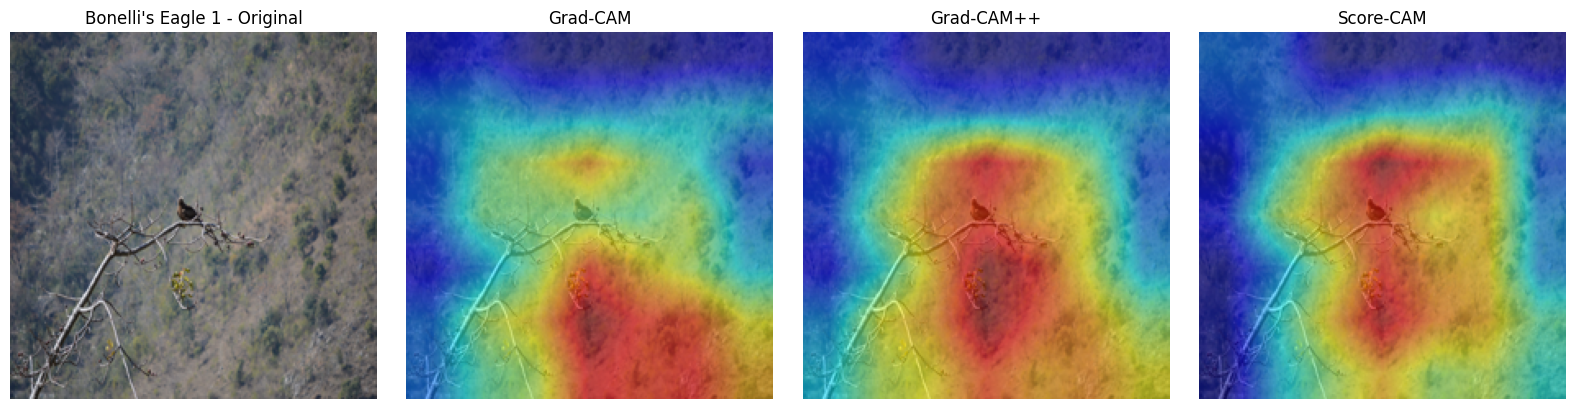

In [12]:
show_all_cams(bonegl_1_rgb, bonegl_1_t, "Bonelli's Eagle 1")

The model’s top prediction for this image was “cliff” (0.45), which was already an indication that it was paying more attention to the background than the bird itself.

By looking at the three CAM visualizations, this further confirms that pattern:

- Grad-CAM highlights a broad red region that covers much of the rocky hillside. There is a very faint amount of activation (more yellowish-green than red) around the actual eagle.

- Grad-CAM++ produces a slightly sharper map but still keeps the highest intensity on the background texture rather than on the the bird’s outline.

- Score-CAM looks very similar to Grad-CAM++, wherein we can see that the red activation area lies in middle and lower parts of the image where the background cliff pattern dominates. However, the activation is slightly fainter than Grad-CAM++.

Overall, all three methods show that the model was mostly focused on the background — things like the rocky texture and slope patterns — instead of the eagle itself. From the original image, we can see why: the bird is small and blends in really well with its surroundings. Thus, the model got distracted by the scenery rather than recognizing the actual subject.

#### Image #2: Bonelli's Eagle 2

100%|██████████| 128/128 [06:19<00:00,  2.96s/it]


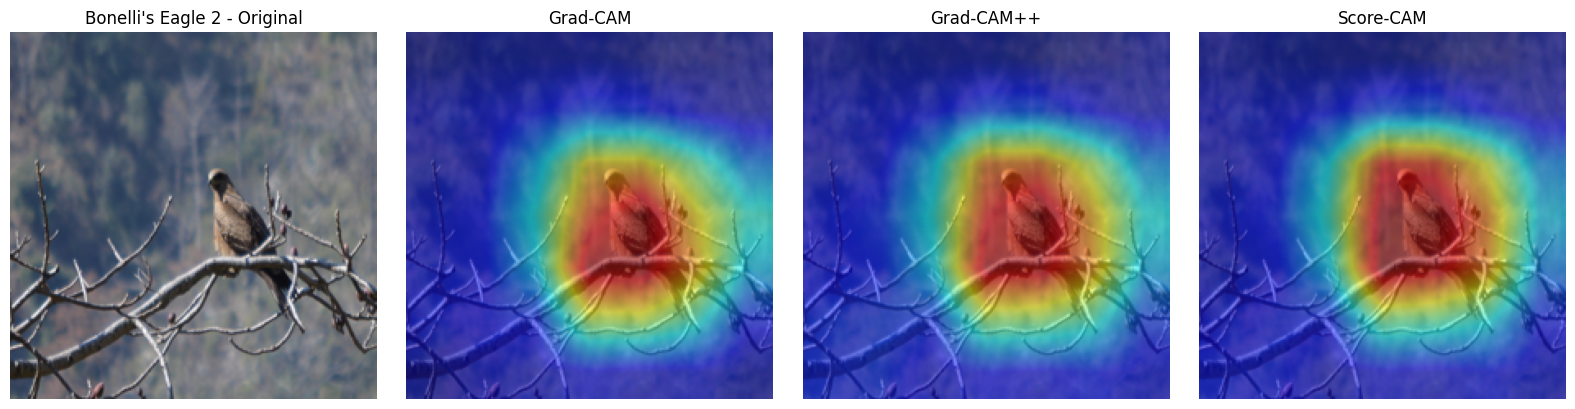

In [13]:
show_all_cams(bonegl_2_rgb, bonegl_2_t, "Bonelli's Eagle 2")

For Bonelli's Eagle image #2, the model’s top prediction was “kite” (0.39) — which is a lot closer to the correct class compared to Bonelli's Eagle image #1 above. Visually (and by comparing it with a Kite bird from Google images), the bird’s shape and posture slightly do resemble a kite, so this prediction makes sense. Because this image is a bit clearer and the bird is more centered, ResNet and CAM maps are able focus more on the bird itself.

- Grad-CAM shows strong red activation right over the bird’s body and wings, meaning those regions (i.e. the bird) were the main cues for classification.

- Grad-CAM++ shows the same region, though it highlights the bird’s head and chest area a bit more strongly compared to Grad-CAM, suggesting that the model is focusing on finer details.

- Lastly, Score-CAM also produces a very similar result (albeit more strongly compared to Grad-CAM and Grad-CAM++), again emphasizing the central bird with less attention to the branches or background.

Overall, this is a good example of the model paying attention to the right object for the right reason. Though it is not able to identify the exact species - confusing the Eagle for a kite — nonetheless, the activation maps show that it was focusing on the bird itself this time rather than the background.

#### Image #3: Chestnut-bellied Rock Thrush 1

100%|██████████| 128/128 [07:05<00:00,  3.32s/it]


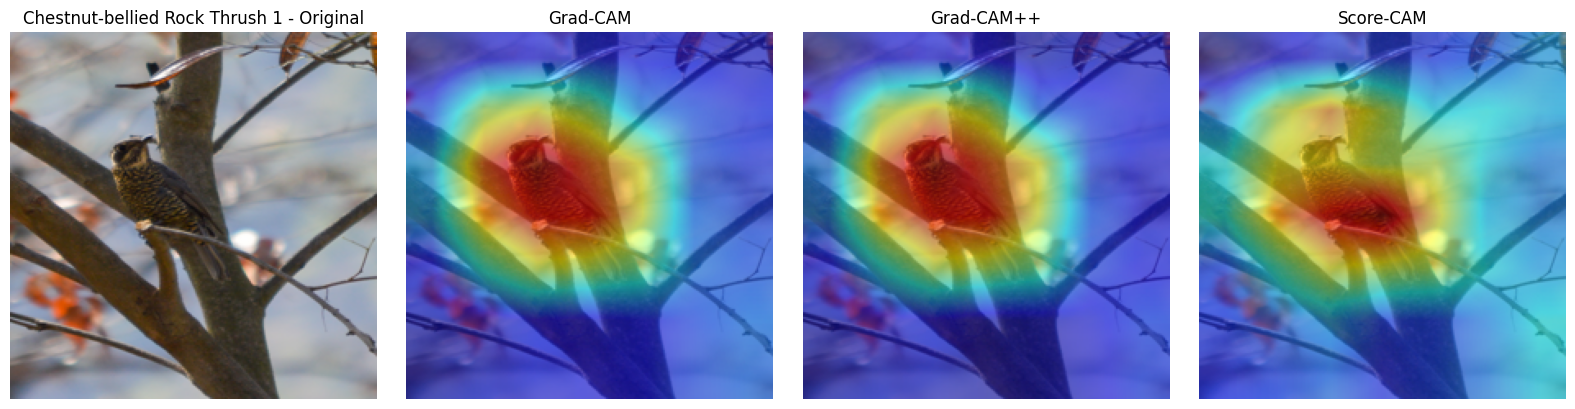

In [14]:
show_all_cams(cbrtsh_1_rgb, cbrtsh_1_t, "Chestnut-bellied Rock Thrush 1")

The model predicted this image as “quail” (0.57), which isn’t accurate but does make some sense given the overall color pattern and body shape. The bird’s rounded form and short tail might have reminded the model of a ground bird like a quail (I am making this statement by comparing this image to quail bird images from Google photos)

In the CAM visualizations, all three methods show strong attention on the bird itself, especially around its head and chest area:

- Grad-CAM highlights the center of the body and part of the surrounding branches.

- Grad-CAM++ sharpens that focus a bit more, narrowing in on the bird’s upper body and reducing the background influence.

- I think Score-CAM looks quite similar, however, the activation area is very mildly focused on the bird's belly region. It weakly captures the overall bird and the surrounding branch area.

Overall, this is very similar to image #2 above (Bonelli's Eagle 2) where the model is looking in the right place but drawing the wrong conclusion. It’s focusing properly on the bird, but my guess is that since it hasn’t been trained specifically on Himalayan species, it falls back on a visually similar class from ImageNet. Nonetheless, we can still say that the model is focusing on the correct obejct in the picture, it is just not able to identify what the object (in this case: species) is.

#### Image #4: Chestnut-bellied Rock Thrush 2

100%|██████████| 128/128 [07:03<00:00,  3.31s/it]


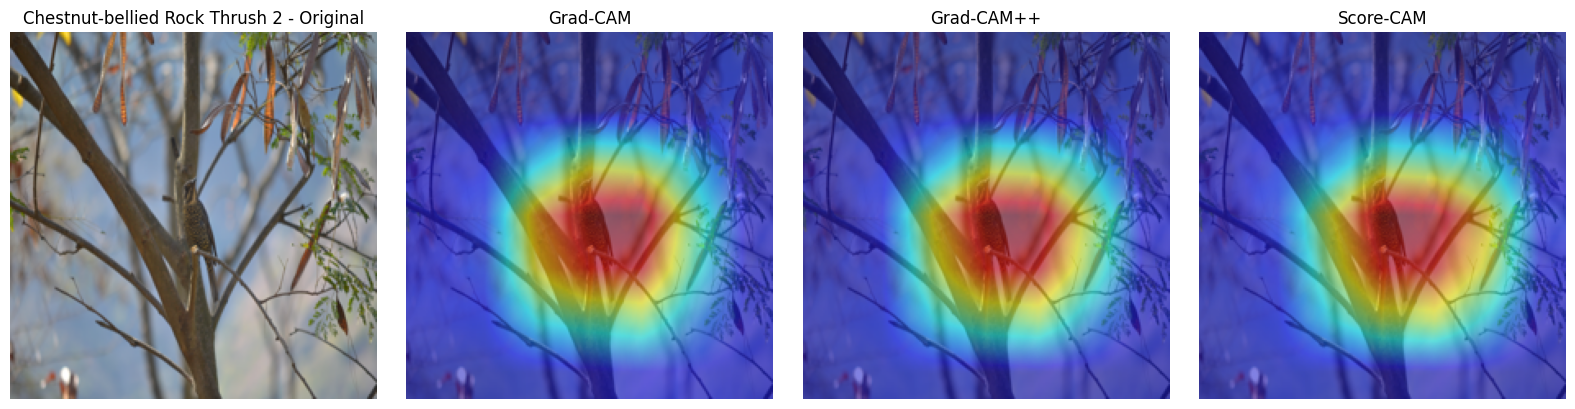

In [15]:
show_all_cams(cbrtsh_2_rgb, cbrtsh_2_t, "Chestnut-bellied Rock Thrush 2")

The model predicted this image as “mongoose” (0.13), which is clearly incorrect but also kind of interesting (and funny). I am assuming the lighting, tree branches, and the bird’s position might have confused the model. From a distance, the shape and brown texture do slightly resemble a small mammal against the tree bark.

- Grad-CAM shows a wide red activation over the center of the image, spreading across both the bird and nearby branch intersections.

- Grad-CAM++ as well as Score-CAM are very similar as it also overlaps a lot of the tree structure rather than cleanly isolating the bird - they focus a tad bit more on the right side branch than the bird.

Overall, I think the model isn’t completely sure what to focus on here — it’s picking up the general color and shape patterns but not clearly distinguishing the bird from its surroundings. The confusion with “mongoose” probably comes from the combination of the brown tones, shading, and the vertical tree alignment that mimics the outline of an animal. I think this case is a good example of how even when the model’s guess kind of makes sense from a shape or color point of view, it can still end up guessing the wrong object when the background or context takes over.

#### Image #5:

100%|██████████| 128/128 [06:23<00:00,  3.00s/it]


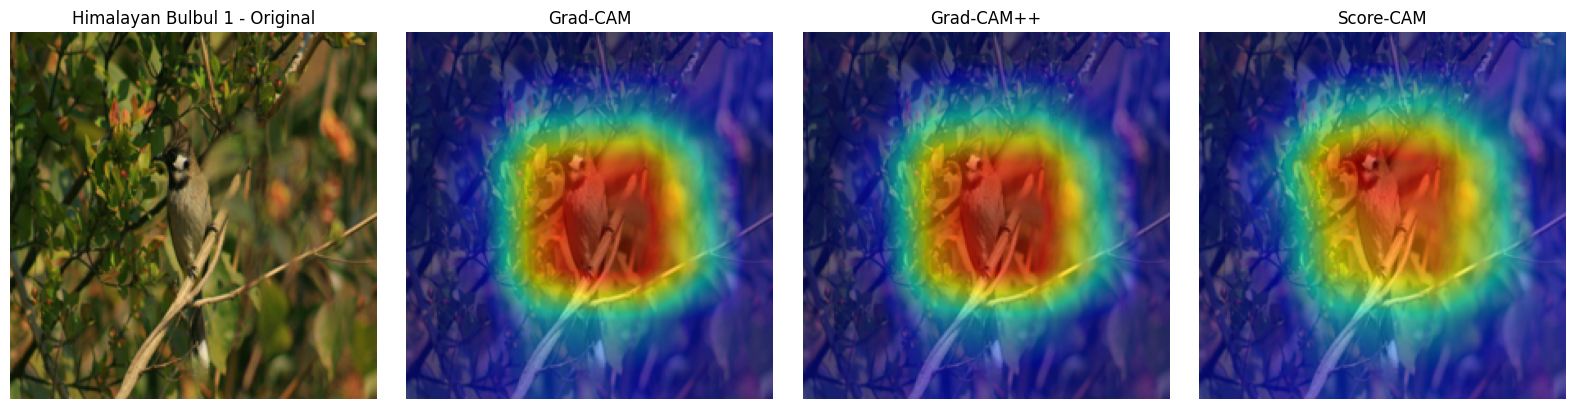

In [16]:
show_all_cams(himbul_1_rgb, himbul_1_t, "Himalayan Bulbul 1")

The model predicted this image as “bulbul” (0.57), which is exactly right. The bird’s posture, the relatively unique crest on its head, and the lighter patch around its face are strong visual cues that likely helped the model make this correct call. This is further emphasized by looking at the CAM visualizations wherein all three methods clearly show that the model is focusing on the bird itself:

- Both, Grad-CAM and Grad-CAM++ center its activation directly on the bird’s body and face, with a tight red region around the head and chest.

- Score-CAM looks very similar, though its heatmap spreads just a bit wider across the body and nearby foliage.

Overall, this is a great example of the model paying attention to the right object for the right reason. The activations show that it’s locking onto distinctive features of the bulbul—its crest, face pattern, and body shape—rather than being distracted by the surrounding greenery. My hypothesis is that Bulbul is a more common bird than the other two hence ResNet-50 is able to correctly identify it.

#### Image #6:

100%|██████████| 128/128 [05:51<00:00,  2.75s/it]


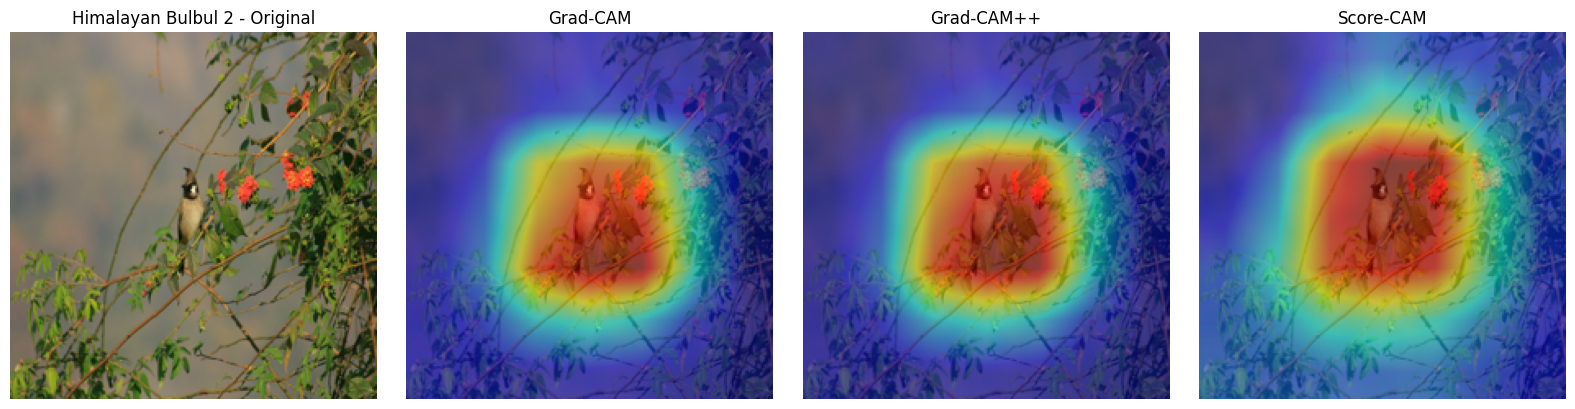

In [17]:
show_all_cams(himbul_2_rgb, himbul_2_t, "Himalayan Bulbul 2")

Similar to the Bulbul #1 above, the model correctly predicted this image as “bulbul” (0.84) with higher confidence this time. This makes sense because the bird is clearly visible, and its key features — the crest, face patch, and upright posture — stand out sharply against the background (atleast relative to Himalayan Bulbul #1). The CAM visualizations line up nicely with this correct prediction:

Grad-CAM shows strong activation directly over the bird, mainly around the head and chest.

Grad-CAM++ tightens that focus even more, highlighting the bird’s upper body while filtering out much of the surrounding foliage.

Score-CAM looks very similar, keeping most of its red activation concentrated on the bird and only slightly extending into the nearby branch area.

Overall, I think this was the best prediction I got so far — the model not only made the right prediction but also focused on the right regions in the picture to do so. It’s clearly identifying the bulbul based on its distinct facial pattern and crest (even more accurately than Bulbul #1), not on the background or context.

### Final thoughts

I found this assignment really interesting as a way to understand how explainable AI can help us understand what deep learning models actually “see” when classifying images. Using the pre-trained ResNet-50, I was able to test how a pre-trained model performs on Himalayan bird species and then use Grad-CAM, Grad-CAM++, and Score-CAM to actually understand why it made those predictions based on areas it highlighted as 'activation' areas.

From the initial results, I understood that the model doesn’t always focus where a human would.

For instance, in both of the Bonelli’s Eagle's images, the strongest activations were over the rocky background instead of the bird itself—explaining why the model predicted “cliff” or “valley.” On the other hand, for the Himalayan Bulbul images, the attention maps clearly focused on the bird’s head and body, and the model’s predictions were, both, accurate and relatively more confident. The Chestnut-bellied Rock Thrush results sat somewhere in between since ResNet-50 looked at the right area but still confused the species. I strongly believe it is because these Himalayan birds may not have been part of the ImageNet training set and because they also share similar color patterns with common classes that would more likelier be in the training set such as quails, mongooses, or small ground birds.

Comparing the different visualization methods, I found that Grad-CAM++ generally produced cleaner, more localized attention maps than vanilla Grad-CAM and Score-CAM (though of course, this is subjective depending on the picture). It seemed better at emphasizing smaller regions like the head or wings, while Grad-CAM (and at times - Score-CAM) was more faint in their activation shades. Nonehteless, seeing all three side by side helped me confirm that even when the model makes mistakes, the reasoning behind those mistakes can still be visually explained.

Overall, this assignment showed me how important explainability is, especially in ecological applications. If deep learning is going to be used for biodiversity monitoring or species identification, we need to understand when and why it might be relying on the wrong cues—like background textures or lighting conditions. My motivation for using bird species (and more broadly, on focusing on conservation) is because for my Capstone project, my group is partnered with 'The Conservation Fund' and I wanted to identify if I could apply some explainability methods in my capstone models as well.

#### Notes

I used Chatgpt-5 over the span of few days to help me with most of the code. The explanations and interpretations are more or less my own though I did use a little bit of help to understand swhat the initial red area and values meant (for instance, I didn't know that the red regions were called 'activation' regions).